In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt

import experiments.helpers.training as training


In [2]:
from torchdiffeq import odeint

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def trace_df_dz(f, z):
    """Calculates the trace of the Jacobian df/dz.
    
    Taken from: https://github.com/rtqichen/ffjord/blob/master/lib/layers/odefunc.py#L13
    """
    sum_diag = 0.
    for i in range(z.shape[1]):
        sum_diag += torch.autograd.grad(f[:, i].sum(), z, create_graph=True)[0].contiguous()[:, i].contiguous()

    return sum_diag.contiguous()

# Simple example of lerning a normal distribution

In [5]:
args = {
    'niters': 5000,
    'lr': 1e-3,
    'num_samples': 500,
    'hidden_dim': 20,
    'width': 20,
    'results_dir': 'results'
}

The distribution to be learnt is $\mathcal{N}(0, 5)$.

In [6]:
def get_batch_normal(num_samples):
    x = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([5.0])).sample(sample_shape=torch.Size([num_samples])).type(torch.float32)
    logp_diff_t1 = torch.zeros(num_samples, 1).type(torch.float32)
    
    return x, logp_diff_t1

We'll use a simple neural network with one hidden layer.

In [7]:
class ODEnn(nn.Module):

    def __init__(self, in_out_dim=1, hidden_dim=20):
        super(ODEnn, self).__init__()

        self.net = nn.Sequential(
            # ODE-Net's neural network architecture: 1 hidden layer with 50 neurons, tanh activation, 2 output neurons
            nn.Linear(in_out_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, in_out_dim),
        )

        # Initialize the weights and biases of the network for better convergence
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    # Define the forward pass of the network
    def forward(self, t, states):
        z = states[0]
        logp_z = states[1]
        
        with torch.set_grad_enabled(True):
            z.requires_grad_(True)
            
            dz_dt = self.net(z)
            dlogp_z_t = -trace_df_dz(dz_dt, z).view(-1,1)
            
        return (dz_dt, dlogp_z_t)

Define the vector field here. We'll use the ODE-Net architecture with starting time 0 and terminal time 10. The initial distribution is $\mathcal{N}(0, 1)$.

In [8]:
t0 = 0
t1 = 10
func = ODEnn(in_out_dim=1, hidden_dim=50).to(device)
optimizer = optim.Adam(func.parameters(), lr=args['lr'])

p_z0 = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

Let's train the network.

In [9]:
loss_meter = training.RunningAverageMeter(0.97)
print("Number of parameters: {}".format(sum(p.numel() for p in func.parameters())))

for itr in range(1, args['niters']+1):
    optimizer.zero_grad()
    
    x, logp_diff_t1 = get_batch_normal(args['num_samples'])
    
    z_t, logp_diff_t = odeint(
        func,
        (x, logp_diff_t1),
        torch.tensor([t1, t0]).type(torch.float32).to(device),
        atol=1e-5,
        rtol=1e-5,
        method='dopri5'
    )
    
    z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1]
    
    logp_x = p_z0.log_prob(z_t0) - logp_diff_t0
    
    loss = -logp_x.mean(0)
    
    loss.backward()
    optimizer.step()
    
    loss_meter.update(loss.item())
    
    if itr % 100 == 0:
        print('Iter: {}, running avg loss: {:.4f}'.format(itr, loss_meter.avg))

Number of parameters: 151
Iter: 100, running avg loss: 3.5364
Iter: 200, running avg loss: 3.1755
Iter: 300, running avg loss: 3.1453
Iter: 400, running avg loss: 3.1029
Iter: 500, running avg loss: 3.0796
Iter: 600, running avg loss: 3.0550
Iter: 700, running avg loss: 3.0406
Iter: 800, running avg loss: 3.0322
Iter: 900, running avg loss: 3.0334
Iter: 1000, running avg loss: 3.0292
Iter: 1100, running avg loss: 3.0312
Iter: 1200, running avg loss: 3.0305
Iter: 1300, running avg loss: 3.0390
Iter: 1400, running avg loss: 3.0251
Iter: 1500, running avg loss: 3.0269
Iter: 1600, running avg loss: 3.0266
Iter: 1700, running avg loss: 3.0313
Iter: 1800, running avg loss: 3.0303
Iter: 1900, running avg loss: 3.0354
Iter: 2000, running avg loss: 3.0383
Iter: 2100, running avg loss: 3.0281
Iter: 2200, running avg loss: 3.0318
Iter: 2300, running avg loss: 3.0285
Iter: 2400, running avg loss: 3.0289
Iter: 2500, running avg loss: 3.0248
Iter: 2600, running avg loss: 3.0303
Iter: 2700, running a

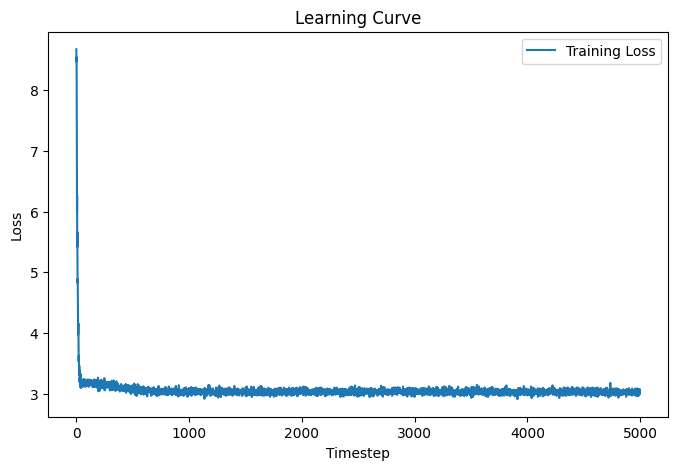

In [10]:
loss_meter.plot_history()

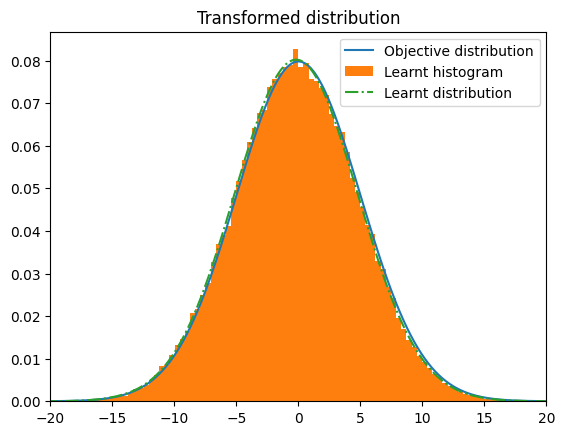

In [11]:
# Get points from the original distribution
y_0 = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0])).sample(sample_shape=torch.Size([100000])).type(torch.float32)
# Get their log probability
logp_t0 = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0])).log_prob(y_0).type(torch.float32)

# Transform the points
y_t_empirical, _ = odeint(
        func, 
        (y_0, logp_t0), 
        torch.tensor([t0, t1]).type(torch.float32), 
        method='dopri5', 
        atol=1e-5, 
        rtol=1e-5)

# Plot the objective distribution
x = np.linspace(-20, 20, 1000)
x_tensor = torch.tensor(x).type(torch.float32)
obj = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([5.0])).log_prob(x_tensor).type(torch.float32)

# Plot the learnt distribution
x_tensor = torch.tensor(np.linspace(-15,15,1000)).type(torch.float32)
origin_d = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0])).log_prob(x_tensor).type(torch.float32)

x_t, logp_x_t = odeint(
        func, 
        (x_tensor.view(-1,1), origin_d.view(-1,1)), 
        torch.tensor([t0, t1]).type(torch.float32), 
        method='dopri5', 
        atol=1e-5, 
        rtol=1e-5
    )
x_t, logp_x_t = x_t[-1].detach().cpu().numpy(), logp_x_t[-1].exp().detach().cpu().numpy()

#plt.hist(, bins=100, density=True, label='Original histogram')
plt.plot(x, obj.exp(), label='Objective distribution')
#plt.hist(get_batch_normal(100000)[0].view(100000), bins=100, density=True, label='Samples')
plt.hist(y_t_empirical[-1].detach().cpu().numpy(), bins=100, density=True, label='Learnt histogram')
plt.plot(x_t, logp_x_t, '-.', label='Learnt distribution')
plt.title('Transformed distribution')
plt.xlim(-20,20)
plt.legend()
plt.show()

Now let's see how the distribution changes over time.

In [12]:
from IPython.display import display, HTML
from PIL import Image
x_0 = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0])).sample(sample_shape=torch.Size([100000])).type(torch.float32)

logp_t0 = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0])).log_prob(y_0).type(torch.float32)

times = np.linspace(t0, t1, 10)

x_t, _ = odeint(
        func, 
        (x_0, logp_t0), 
        torch.tensor(times).type(torch.float32), 
        method='dopri5', 
        atol=1e-5, 
        rtol=1e-5
    )

x_t = x_t.detach().cpu().numpy()

if not os.path.exists('cnf_one_images'):
    os.makedirs('cnf_one_images')

# Define the function to generate the plot
def plot_and_save(i):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    plt.suptitle('Transformed distribution at time t={:.2f}'.format(times[i]))
    plt.tight_layout()
    
    
    ax.plot(x, obj.exp(), label='Objective distribution')
    ax.hist(x_t[i], bins=100, density=True)
    plt.xlim(-20,20)
    plt.ylim(0,0.5)

    # Save the plot as an image
    plt.savefig(os.path.join('cnf_one_images','frame{}.png'.format(i)))
    plt.close()


# Generate the GIF
for i in range(10):
    plot_and_save(i)

# Create the GIF using imageio
gif_images = [os.path.join('cnf_one_images','frame{}.png'.format(i)) for i in range(10)]

img, *imgs = [Image.open(img) for img in gif_images]
gif_path = os.path.join('cnf_one_images','result.gif')
img.save(fp=gif_path, format='GIF', append_images=imgs,
         save_all=True, duration=500, loop=0)
display(HTML(f'<img src="{gif_path}">'))
img.close()
for im in imgs:
    im.close()

# A "harder" example to learn a two modal distribution

In [13]:
args = {
    'niters': 10000,
    'lr': 1e-3,
    'num_samples': 1000,
    'hidden_dim': 20,
    'width': 20,
    'results_dir': 'results'
}

In [14]:
class HyperNetwork(nn.Module):
    """Hyper-network allowing f(z(t), t) to change with time.

    Taken from: https://github.com/rtqichen/torchdiffeq/blob/master/examples/cnf.py
    """

    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()

        blocksize = width * in_out_dim

        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 3 * blocksize + width)

        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.blocksize = blocksize

    def forward(self, t):
        # predict params
        params = t.reshape(1, 1)
        params = torch.tanh(self.fc1(params))
        params = torch.tanh(self.fc2(params))
        params = self.fc3(params)

        # restructure
        params = params.reshape(-1)
        W = params[:self.blocksize].reshape(self.width, self.in_out_dim, 1)

        U = params[self.blocksize:2 * self.blocksize].reshape(self.width, 1, self.in_out_dim)

        G = params[2 * self.blocksize:3 * self.blocksize].reshape(self.width, 1, self.in_out_dim)
        U = U * torch.sigmoid(G)

        B = params[3 * self.blocksize:].reshape(self.width, 1, 1)
        return [W, B, U]

In [15]:
# Continuous normalising flow
class CNF(nn.Module):
    """Continuous normalising flow model.
    
    Taken from: https://github.com/rtqichen/torchdiffeq/blob/master/examples/cnf.py
    """

    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()
        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.hyper_net = HyperNetwork(in_out_dim, hidden_dim, width)

    def forward(self, t, states):
        z = states[0]
        logp_z = states[1]

        batchsize = z.shape[0]

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)

            W, B, U = self.hyper_net(t) # Parameters from the hypernetwork
            Z = torch.unsqueeze(z, 0).repeat(self.width, 1, 1)
            h = torch.tanh(torch.matmul(Z, W) + B)
            dz_dt = torch.matmul(h, U).mean(0)  # Basically, f_{theta}(t, z(t))

            dlogp_z_dt = -trace_df_dz(dz_dt, z).view(batchsize, 1)  # -tr(df/dz) -> Instantaneous change of variables theorem

        return (dz_dt, dlogp_z_dt)

## Objective distribution
We'll try to learn a bimodal distribution generated by two beta processes. The Beta distribution has pdf:
$$
f(x; \alpha, \beta) = \frac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha, \beta)}
$$
where $B(\alpha, \beta)$ is the beta function. The beta function is defined as:
$$
B(\alpha, \beta) = \int_0^1 t^{\alpha-1}(1-t)^{\beta-1} dt
$$
The first process has parameters $\alpha=2, \beta=5$ and the second process has parameters $\alpha=5, \beta=2$. Both processes will be mixed with equal probability.


In [16]:
def get_batch(num_samples):
    alpha = 2
    beta = 5
    x1 = torch.distributions.beta.Beta(alpha, beta).sample(sample_shape=torch.Size([num_samples // 2, 1])).type(
        torch.float32)

    alpha = 5
    beta = 2
    x2 = torch.distributions.beta.Beta(alpha, beta).sample(
        sample_shape=torch.Size([num_samples - num_samples // 2, 1])).type(torch.float32)

    # Sample from the chosen process
    x = torch.cat([x1, x2])
    # Shuffle the samples
    x = x[torch.randperm(num_samples)]
    logp_diff_t1 = torch.zeros(num_samples, 1).type(torch.float32)

    return x, logp_diff_t1

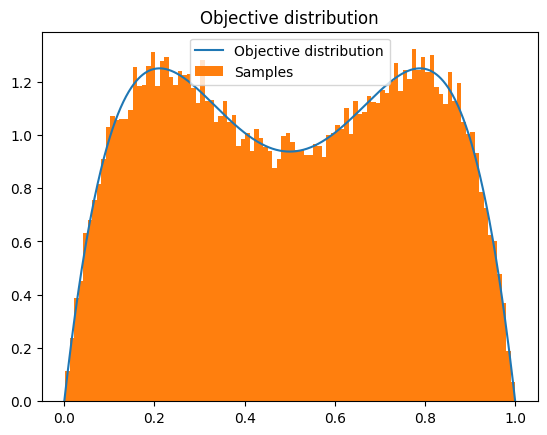

In [17]:
from scipy.stats import beta
import matplotlib.pyplot as plt

# Plot the objective distribution
y_points, _ = get_batch(50000)
x = np.linspace(0, 1, 1000)
y = 0.5 * beta.pdf(x, 2, 5) + 0.5 * beta.pdf(x, 5, 2)

plt.plot(x, y, label='Objective distribution')
plt.hist(y_points.view(50000), bins=100, density=True, label='Samples')
plt.title('Objective distribution')
plt.legend()
plt.show()


In [18]:
t0 = 0
t1 = 10
func = CNF(in_out_dim=1, hidden_dim=args['hidden_dim'], width=args['width']).to(device)
optimizer = optim.Adam(func.parameters(), lr=args['lr'])

p_z0 = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

In [19]:
loss_meter = training.RunningAverageMeter()
print("Number of parameters: {}".format(sum(p.numel() for p in func.parameters())))

for itr in range(1, args['niters'] + 1):
    optimizer.zero_grad()
    
    x, logp_diff_t1 = get_batch(args['num_samples'])
    
    z_t, logp_z_t = odeint(
        func, 
        (x, logp_diff_t1), 
        torch.tensor([t1, t0]).type(torch.float32), 
        method='dopri5', 
        atol=1e-5, 
        rtol=1e-5)
    
    z_t0, logp_diff_t0 = z_t[-1], logp_z_t[-1]
    
    logp_x = p_z0.log_prob(z_t0).to(device) - logp_diff_t0.view(-1)
    
    loss = -torch.mean(logp_x)
    
    loss.backward()
    optimizer.step()
    
    loss_meter.update(loss.item())
    
    if itr % 10 == 0:
        print('Iter: {}, running avg loss: {:.4f}'.format(itr, loss_meter.avg))


Number of parameters: 2140
Iter: 10, running avg loss: 1.0325
Iter: 20, running avg loss: 0.9880
Iter: 30, running avg loss: 0.9132
Iter: 40, running avg loss: 0.8434
Iter: 50, running avg loss: 0.7778
Iter: 60, running avg loss: 0.7168
Iter: 70, running avg loss: 0.6610
Iter: 80, running avg loss: 0.6103
Iter: 90, running avg loss: 0.5639
Iter: 100, running avg loss: 0.5215
Iter: 110, running avg loss: 0.4827
Iter: 120, running avg loss: 0.4461
Iter: 130, running avg loss: 0.4129
Iter: 140, running avg loss: 0.3817
Iter: 150, running avg loss: 0.3539
Iter: 160, running avg loss: 0.3266
Iter: 170, running avg loss: 0.3014
Iter: 180, running avg loss: 0.2766
Iter: 190, running avg loss: 0.2530
Iter: 200, running avg loss: 0.2301
Iter: 210, running avg loss: 0.2087
Iter: 220, running avg loss: 0.1883
Iter: 230, running avg loss: 0.1687
Iter: 240, running avg loss: 0.1508
Iter: 250, running avg loss: 0.1342
Iter: 260, running avg loss: 0.1190
Iter: 270, running avg loss: 0.1055
Iter: 280,

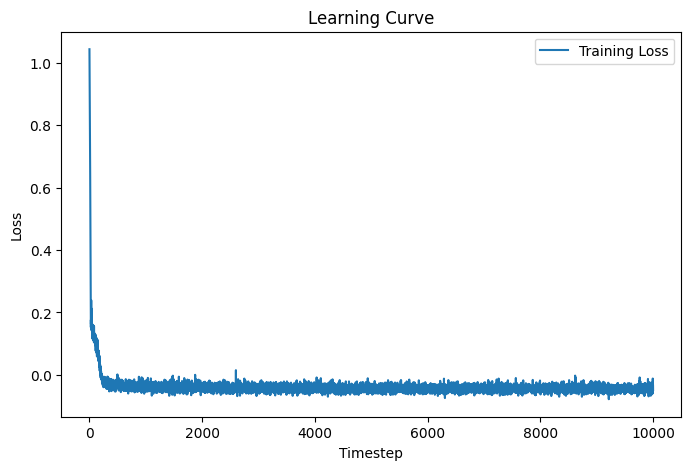

In [20]:
loss_meter.plot_history()

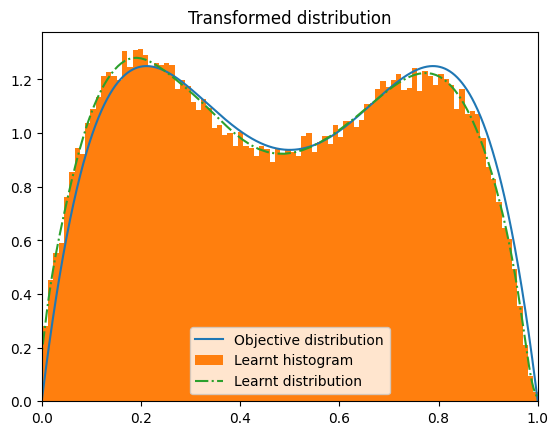

In [21]:
# Get points from the original distribution
y_0 = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0])).sample(sample_shape=torch.Size([100000])).type(torch.float32)
# Get their log probability
logp_t0 = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0])).log_prob(y_0).type(torch.float32)

# Transform the points
y_t_empirical, _ = odeint(
        func, 
        (y_0, logp_t0), 
        torch.tensor([t0, t1]).type(torch.float32), 
        method='dopri5', 
        atol=1e-5, 
        rtol=1e-5)

# Plot the objective distribution
x = np.linspace(0, 1, 1000)
obj = 0.5 * beta.pdf(x, 2, 5) + 0.5 * beta.pdf(x, 5, 2)

# Plot the learnt distribution
x_tensor = torch.tensor(np.linspace(-20,20,1000)).type(torch.float32)
origin_d = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0])).log_prob(x_tensor).type(torch.float32)

x_t, logp_x_t = odeint(
        func, 
        (x_tensor.view(-1,1), origin_d.view(-1,1)), 
        torch.tensor([t0, t1]).type(torch.float32), 
        method='dopri5', 
        atol=1e-5, 
        rtol=1e-5
    )
x_t, logp_x_t = x_t[-1].detach().cpu().numpy(), logp_x_t[-1].exp().detach().cpu().numpy()


#plt.hist(, bins=100, density=True, label='Original histogram')
plt.plot(x, obj, label='Objective distribution')
plt.hist(y_t_empirical[-1].detach().cpu().numpy(), bins=100, density=True, label='Learnt histogram')
plt.plot(x_t, logp_x_t, '-.', label='Learnt distribution')
plt.title('Transformed distribution')
plt.xlim(0,1)
plt.legend()
plt.show()

In [22]:

x_0 = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0])).sample(sample_shape=torch.Size([100000])).type(torch.float32)

logp_t0 = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0])).log_prob(y_0).type(torch.float32)

times = np.linspace(t0, t1, 10)

x_t, _ = odeint(
        func, 
        (x_0, logp_t0), 
        torch.tensor(times).type(torch.float32), 
        method='dopri5', 
        atol=1e-5, 
        rtol=1e-5
    )

x_t = x_t.detach().cpu().numpy()

if not os.path.exists('cnf_one_images_2'):
    os.makedirs('cnf_one_images_2')

# Define the function to generate the plot
def plot_and_save(i):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    plt.suptitle('Transformed distribution at time t={:.2f}'.format(times[i]))
    plt.tight_layout()
    
    
    ax.plot(x, obj, label='Objective distribution')
    ax.hist(x_t[i], bins=100, density=True)
    plt.xlim(-5,5)
    plt.ylim(0,1.3)

    # Save the plot as an image
    plt.savefig(os.path.join('cnf_one_images_2','frame{}.png'.format(i)))
    plt.close()


# Generate the GIF
for i in range(10):
    plot_and_save(i)

# Create the GIF using imageio
gif_images = [os.path.join('cnf_one_images_2','frame{}.png'.format(i)) for i in range(10)]

img, *imgs = [Image.open(img) for img in gif_images]
gif_path = os.path.join('cnf_one_images_2','result.gif')
img.save(fp=gif_path, format='GIF', append_images=imgs,
         save_all=True, duration=500, loop=0)
display(HTML(f'<img src="{gif_path}">'))
img.close()
for im in imgs:
    im.close()